In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import datasets

import random

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Попробуйте видоизменить параметры разобранной на уроке нейронной сети таким образом, чтобы улучшить ее точность.

In [2]:
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    
    return binarized

def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))
    
    for i in range(len(Y)):
        l = layer2[i]
        for j in range(len(l)):
            if l[j] == 1:
                arr[i] = j+1
                
    return arr

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x) * (1 - sigmoid(x))

def normalize(X, axis=1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

def view_err(errors):
    plt.figure(figsize=(8, 2))
    plt.plot(errors)
    plt.xlabel('обучение')
    plt.ylabel('ошибка')
    plt.show()
    
    print(errors[-1])

def view_pred(layer, y, accuracy, name, N=50):
    plt.figure(figsize=(8, 2))
    plt.plot(layer[:N,1], label='Y new')
    plt.plot(y[:N,1], label=f'Y {name}')
    
    plt.title(name)
    plt.xlabel('№ примера')
    plt.ylabel('выход сети и целевой')
    
    plt.legend()
    plt.show()
    
    print(f"Аккуратность нейронной сети {round(accuracy,2)}%")

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa


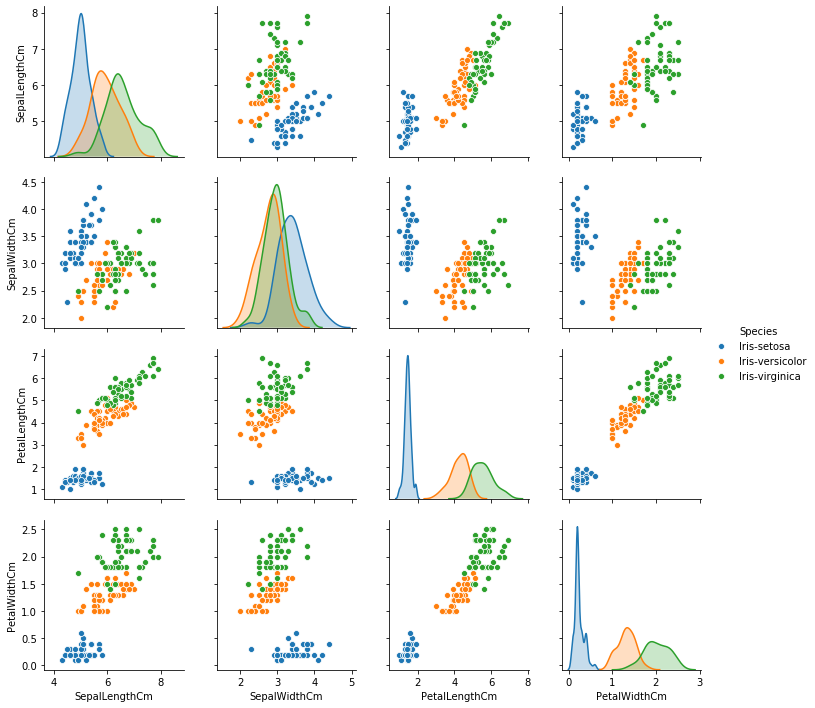

In [3]:
PATH_TO_IRIS = '..\\datas\\Iris.csv'
iris_data = pd.read_csv(PATH_TO_IRIS)
print(iris_data.head())

g = sns.pairplot(iris_data.drop('Id', axis=1), hue="Species")

iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0,1,2], inplace=True)

columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
x = normalize(x.as_matrix())

columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
y = y.as_matrix()
y = y.flatten()
y = to_one_hot(y)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

## Train / Test

In [4]:
class NeuroModel:
    w0 = None
    w1 = None
    w2 = None
    
    def __init__(
        self,
        hidden_neurons1 = 1,
        hidden_neurons2 = 1,
        learning_rate = 0.1,
        iterations = 100
    ):
    
        self.hidden_neurons1 = hidden_neurons1
        self.hidden_neurons2 = hidden_neurons2
        self.learning_rate = learning_rate
        self.iterations = iterations
    
    def fit(self, X, y):
        errors = []
        
        np.random.seed(42)
        self.w0 = 2*np.random.random((4, self.hidden_neurons1)) - 1
        self.w1 = 2*np.random.random((self.hidden_neurons1, self.hidden_neurons2)) - 1
        self.w2 = 2*np.random.random((self.hidden_neurons2, 3)) - 1
        
        for i in range(self.iterations):
            # feed forward
            layer0 = X
            layer1 = sigmoid(np.dot(layer0, self.w0))
            layer2 = sigmoid(np.dot(layer1, self.w1))
            layer3 = sigmoid(np.dot(layer2, self.w2))

            # back propagation
            layer3_error = y - layer3
            layer3_delta = layer3_error * sigmoid_deriv(layer3)

            layer2_error = layer3_delta.dot(self.w2.T)
            layer2_delta = layer2_error * sigmoid_deriv(layer2)

            layer1_error = layer2_delta.dot(self.w1.T)
            layer1_delta = layer1_error * sigmoid_deriv(layer1)

            self.w2 += layer2.T.dot(layer3_delta) * self.learning_rate
            self.w1 += layer1.T.dot(layer2_delta) * self.learning_rate
            self.w0 += layer0.T.dot(layer1_delta) * self.learning_rate

            # model metric
            error = np.mean(np.abs(layer3_error))
            errors.append(error)
            accuracy = (1 - error) * 100
            
        return layer3, errors, accuracy
            
    def pred(self, X, y):
        layer0 = X
        layer1 = sigmoid(np.dot(layer0, self.w0))
        layer2 = sigmoid(np.dot(layer1, self.w1))
        layer3 = sigmoid(np.dot(layer2, self.w2))

        layer3_error = y - layer3

        # model metric
        error = np.mean(np.abs(layer3_error))
        accuracy = (1 - error) * 100

        error = np.mean(np.abs(layer3_error))
        
        return layer3, error, accuracy

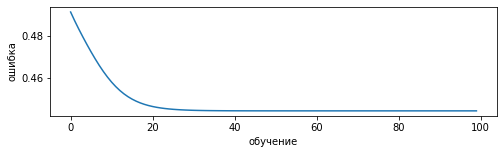

0.4443979915651704


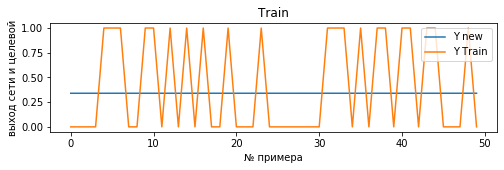

Аккуратность нейронной сети 55.56%


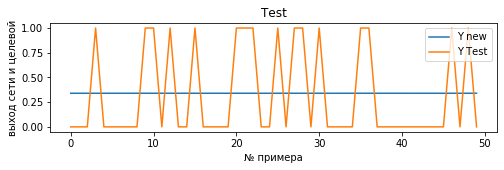

Аккуратность нейронной сети 55.56%


In [5]:
model1 = NeuroModel(hidden_neurons1 = 1,
                    hidden_neurons2 = 1,
                    learning_rate = 0.1,
                    iterations = 100)

train_pred = model1.fit(X_train, y_train)
test_pred = model1.pred(X_test, y_test)

view_err(train_pred[1])
view_pred(layer=train_pred[0], y=y_train, accuracy=train_pred[2], name='Train')
view_pred(layer=test_pred[0], y=y_test, accuracy=train_pred[2], name='Test')

### При низких показателях обучение не произошло

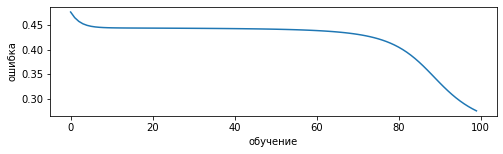

0.2755643784568334


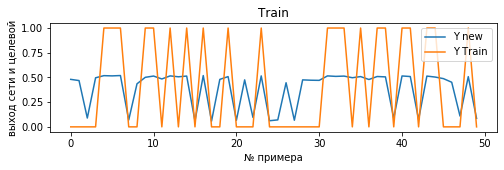

Аккуратность нейронной сети 72.44%


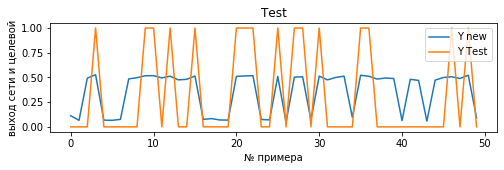

Аккуратность нейронной сети 72.83%


In [6]:
model1 = NeuroModel(hidden_neurons1 = 2,
                    hidden_neurons2 = 2,
                    learning_rate = 0.1,
                    iterations = 100)

train_pred = model1.fit(X_train, y_train)
test_pred = model1.pred(X_test, y_test)

view_err(train_pred[1])
view_pred(layer=train_pred[0], y=y_train, accuracy=train_pred[2], name='Train')
view_pred(layer=test_pred[0], y=y_test, accuracy=test_pred[2], name='Test')

### При добавлении нейронов, точность повысилась

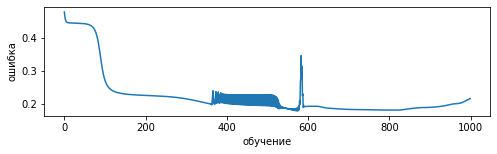

0.21725764741469505


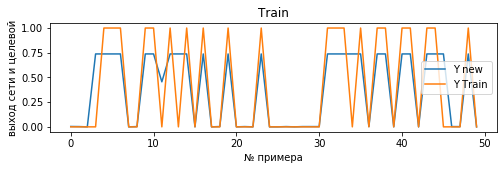

Аккуратность нейронной сети 78.27%


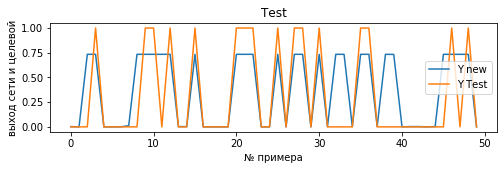

Аккуратность нейронной сети 76.59%


In [7]:
model1 = NeuroModel(hidden_neurons1 = 2,
                    hidden_neurons2 = 2,
                    learning_rate = 0.1,
                    iterations = 1000)

train_pred = model1.fit(X_train, y_train)
test_pred = model1.pred(X_test, y_test)

view_err(train_pred[1])
view_pred(layer=train_pred[0], y=y_train, accuracy=train_pred[2], name='Train')
view_pred(layer=test_pred[0], y=y_test, accuracy=test_pred[2], name='Test')

### При увеличении итераций модель стала уверенней

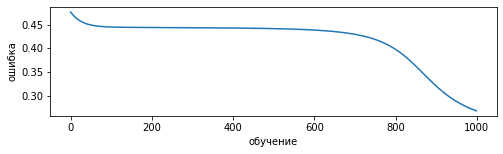

0.26744265137222073


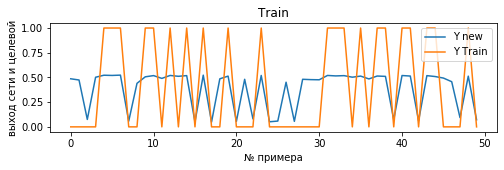

Аккуратность нейронной сети 73.26%


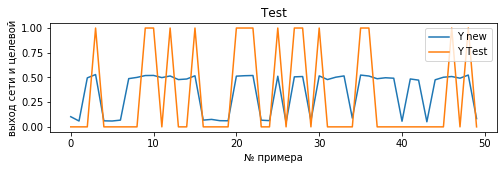

Аккуратность нейронной сети 73.31%


In [8]:
model1 = NeuroModel(hidden_neurons1 = 2,
                    hidden_neurons2 = 2,
                    learning_rate = 0.01,
                    iterations = 1000)

train_pred = model1.fit(X_train, y_train)
test_pred = model1.pred(X_test, y_test)

view_err(train_pred[1])
view_pred(layer=train_pred[0], y=y_train, accuracy=train_pred[2], name='Train')
view_pred(layer=test_pred[0], y=y_test, accuracy=test_pred[2], name='Test')

### При увеличении шага обучения скорость обучения упала

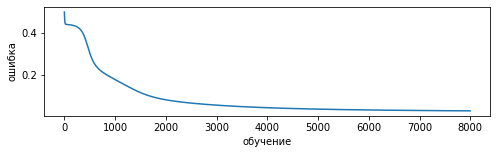

0.029163097749691894


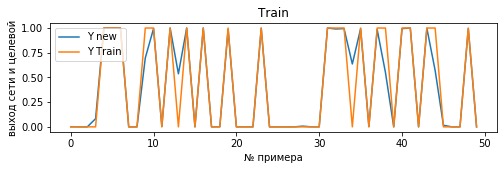

Аккуратность нейронной сети 97.08%


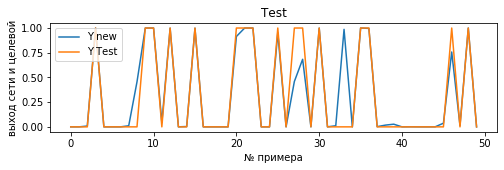

Аккуратность нейронной сети 95.96%


In [9]:
model1 = NeuroModel(hidden_neurons1 = 8,
                    hidden_neurons2 = 8,
                    learning_rate = 0.01,
                    iterations = 8000)

train_pred = model1.fit(X_train, y_train)
test_pred = model1.pred(X_test, y_test)

view_err(train_pred[1])
view_pred(layer=train_pred[0], y=y_train, accuracy=train_pred[2], name='Train')
view_pred(layer=test_pred[0], y=y_test, accuracy=test_pred[2], name='Test')

# Проведите анализ:
# Что приводит к ухудшению точности нейронной сети? Что приводит к увеличению ее точности?

##### Ответ:
Замечено, что как и с моделями машинного обучения здесь играет роль правильная настройка гиперпараметров - слишком низкие значения приводят к недообученности модели, что снижает её точность, слишком высокие приводят к переобучению